In [34]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import seaborn as sns
import pandas as pd

sns.set_theme(font_scale=1.7, style='whitegrid')

# Esercitazione 3

## 0 - Appunti e introduzione

Nella scorsa lezione abbiamo introdotto alcune strategie per aumentare le performance dei codici scritti in `Python`, tra cui in particolare utilizziamo numba. 

Estendere il `back-end` utilizzando altre strategie è importante. Se necessito una fz molto performante su `tf` posso, ad esempio, scriverla in `C++` e poi fornirla a `tf`.

#### Che framework scegliere?

Ci sono un sacco di opzioni. Diciamo che `tf` è il più utilizzato tra tutti. Seguono `keras` e `PyTorch`. Per scegliere conviene analizzare _learning curve, developement pace, community size, papers associate al framework (tf ad esempio consente agli utenti di interagire ed aprire degli issues su GitHub), stabilità nel tempo e performance_.

---

### Su TensorFlow

#### Variabili e tensori

Posso decidere dove e come allocare la memoria. se scrivo `with tf.device('CPU:0')` sto scegliendo la CPU. Alternativamente `same... ('GPU:0')`.

- `tf.Variable` è una variabile il cui valore è modificabile in futuro utilizzando `tf.assign()`;
- `tf.constant` è una variabile il cui valore viene mantenuto costante.

In `C++` non potrei fare questa operazione in meno di 50 righe.

#### Gradienti

Utilizzando `GradientTape` tf interpreta il gradiente della formula funzionale. 

HP di avere un modello lineare, in cui definisco una matrice di pesi e una di bias:

In [4]:
w = tf.Variable(tf.random.normal((3,2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1.,2.,3.]]

In [5]:
with tf.GradientTape() as tape:
    y = tf.nn.sigmoid(x @ w + b)
    loss = tf.reduce_mean(tf.math.square(y))

Abbiamo costruito una loss che è una catena di operazioni. Abbiamo in qualche modo costruito un algoritmo di stocastic gradient descent in completa autonomia. Nelle slide fa un esempio di training su quattro variabili in cui si vede come il `tape` vada a tener conto solo di quelle che rimangono a tutti gli effetti delle `Variable`.

In [6]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])

In [7]:
print(dl_dw, dl_db)

tf.Tensor(
[[0.02938421 0.07696479]
 [0.05876843 0.15392958]
 [0.08815265 0.23089436]], shape=(3, 2), dtype=float32) tf.Tensor([0.02938421 0.07696479], shape=(2,), dtype=float32)


#### tf Module
Possiamo costruire una classe (di seguito alcune note utili se, come me, sei nabb*):

- `__init__` è un costruttore. Metodo invocato automaticamente nel momento in cui si va definire un oggetto che corrisponde alla classe in esame. Contiene i vari data membri, che verranno richiamati tramite il prefisso `self.`;
- `super()` invoca la classe madre quando stiamo programmando utilizzando ereditareità nelle classi. Può essere usato per evitare di ricordarsi il nome della super-classe.

In [8]:
class SimpleModule(tf.Module):
    
    #costruttore 
    def __init__(self, name=None):
        super().__init__(name=name)
        self.a_variable = tf.Variable(5.0, name='train_me')
        self.non_trainable_variable = tf.Variable(5.0, trainable=False)
    
    #azione in chiamata della classe
    def __call__(self, x):
        return self.a_variable * x + self.non_trainable_variable

In [9]:
simple_module = SimpleModule(name="simple")
simple_module(tf.constant(5.0))

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [10]:
# se voglio costruire un layer dense

class Dense(tf.Module):
    
    #costruttore
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name='w')
        self.b = tf.Variable(tf.zeros([out_feature]), name='b')
    
    # azione in chiamata della classe
    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.relu(y)

---

### Su Keras

Keras rientra nel mondo del high-level. Oggi è un modulo di `tf` che lavora come API. Un esempio di costruzione tramite Keras:

In [11]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(2, activation="relu"))
model.add(tf.keras.layers.Dense(3, activation="relu"))
model.add(tf.keras.layers.Dense(1))
# ora la rete è inizializzata in modo casuale dal framework
# se la alleniamo questa si adegua ai pattern del mio campione
# però già così una risposta me la da, casuale ma me la da

y = model(tf.ones((1,1)))
model.summary()

y

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (1, 2)                    4         
_________________________________________________________________
dense_1 (Dense)              (1, 3)                    9         
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    4         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>

A questo punto abbiamo due metodi necessari all'utilizzo della rete:

1. `model.compile()` compila la rete;
2. `model.fit()` la allena.

Questa tecnica sequenziale potrebbe non essere sempre utile. Ad esempio quando:

- abbiamo output e input multipli;
- ogni layer ha multiple inputs and outputs;
- vogliamo condivisione tra i layers;
- vogliamo una topologia non lineare.

Ecco che entra in gioco la __API funzionale__. Usando tf dichiariamo un input e indichiamo la shape. A questo punto definiamo i layers separatamente e passiamo manualmente come input degli strati successivi gli output dei precedenti:

In [12]:
inputs = tf.keras.Input(shape=(5,))
x1 = tf.keras.layers.Dense(64, activation='relu')(inputs)
x2 = tf.keras.layers.Dense(64, activation='relu')(x1)
outputs = tf.keras.layers.Dense(1)(x2)

# e adesso trasformo la mia struttura in un modulo standard, così posso usare i metodi
# compile e fit dalla stessa API vista prima

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="MyModel")
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD())

# e se carico anche i dataset a questo punto posso eseguire il training
#history = model.fit(x_train, y_train, batch_size=32, epochs=100)

# e poi valutare il modello con evaluate(x_test, y_test)

## 1 - MLP

Per questo primo esercizio costruisco una classe che chiamo simpleMLP.

In --> h1 --> h2 --> Out

In [13]:
x = np.linspace(-1, 1, 10, dtype=np.float32).reshape(-1, 1)

In [14]:
tf.random.set_seed(0)

class simpleMLP:
    
    # costruisco tutti i pesi nella rete
    def __init__(self, n_input, n_output, n_hidden_1, n_hidden_2):
        # In --> h1    
        self.w1 = tf.Variable(tf.random.normal([n_input, n_hidden_1]), name='w1')
        self.b1 = tf.Variable(tf.random.normal([n_hidden_1]), name='b1')
        
        # h1 --> h2
        self.w2 = tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2]), name='w2')
        self.b2 = tf.Variable(tf.random.normal([n_hidden_2]), name='b2')
        
        # h2 --> Out
        self.w3 = tf.Variable(tf.random.normal([n_hidden_2, n_output]), name='w3')
        self.b3 = tf.Variable(tf.random.normal([n_output]), name='b3')
        
    # chiamata della rete sul dato x    
    def __call__(self, x):
        a1 = tf.nn.sigmoid(tf.matmul(x, self.w1) + self.b1)
        a2 = tf.nn.sigmoid(tf.matmul(a1, self.w2) + self.b2)
        a3 = tf.matmul(a2, self.w3) + self.b3
        return a3
    
    def get_weights(self):
        w = [self.w1, self.w2, self.w3]
        b = [self.b1, self.b2, self.b3]
        return w, b   

In [15]:
# input, output, hidden1, hidden1
first_mlp = simpleMLP(1, 1, 5, 2)

In [16]:
w, b = first_mlp.get_weights()

w[0], b[0]

(<tf.Variable 'w1:0' shape=(1, 5) dtype=float32, numpy=
 array([[ 1.5110626 ,  0.42292204, -0.41969493, -1.0360372 , -1.2368279 ]],
       dtype=float32)>,
 <tf.Variable 'b1:0' shape=(5,) dtype=float32, numpy=
 array([ 1.0668802 ,  0.19454929, -0.53082895,  0.09190082, -0.17753708],
       dtype=float32)>)

In [17]:
y1 = first_mlp(x)

## 2 - Sequential model

In [18]:
# per far sì che i pesi siano inizializzati nello stesso modo
tf.random.set_seed(0)

second_mlp = tf.keras.Sequential()
second_mlp.add(tf.keras.layers.Dense(5, input_shape=(1,), activation="sigmoid", name='l0'))
second_mlp.add(tf.keras.layers.Dense(2, activation="sigmoid"))
second_mlp.add(tf.keras.layers.Dense(1, activation="linear"))

for i in range(3): 
    w[i] = np.asarray(w[i])
    b[i] = np.asarray(b[i])
    
second_mlp.set_weights([w[0], b[0], w[1], b[1], w[2], b[2]])

second_mlp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
l0 (Dense)                   (None, 5)                 10        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 3         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [19]:
y2 = second_mlp(x) 

In [20]:
if not np.allclose(y1, y2):
    raise ValueError("results do not match")
else:
    print("All is good!")

All is good!


## 3 - Manual training with functional API

In [21]:
def f(x):
    return 3 * x + 2

def generate_data():
    
    x = tf.linspace(-2, 2, 200)
    x = tf.cast(x, tf.float32)

    noise = tf.random.normal(shape=x.shape)

    y = f(x) + noise
    return x, y

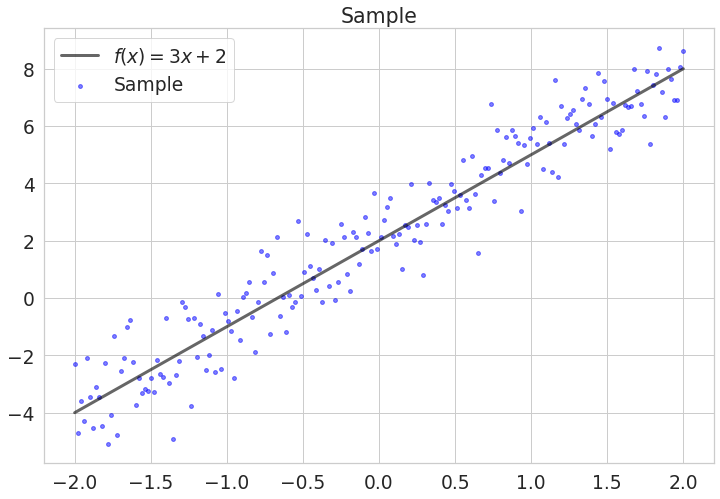

In [22]:
x_data, y_data = generate_data()

plt.figure(figsize=(12,8))
plt.title('Sample')
plt.scatter(x_data, y_data, s=15, alpha=0.5, color='blue', label='Sample')
plt.plot(x_data, f(x_data), color='black', lw=3, alpha=0.6, label=r'$f(x)=3x+2$')
plt.legend()
plt.show()

In [23]:
#--------------------------------------------------------------
# Modulo per una struttura lineare

class LinearModule(tf.Module):
    
    #costruttore 
    def __init__(self, **kwargs):
        super().__init__( **kwargs)
        self.w = tf.Variable(tf.random.normal([1], dtype=tf.float32), name='w')
        self.b = tf.Variable(tf.random.normal([1], dtype=tf.float32), name='b')
    
    #azione in chiamata della classe
    def __call__(self, x):
        return self.w * x + self.b
    
#---------------------------------------------------------------
# Funzione di Costo

def MSE(y_teo, y_est):
    # media ridotta a partire dai due vettori target_y e predicted_y
    return tf.reduce_mean(tf.square(y_teo-y_est))


In [24]:
my_linear = LinearModule()

Vediamo cosa ci propone la rete non allenata.

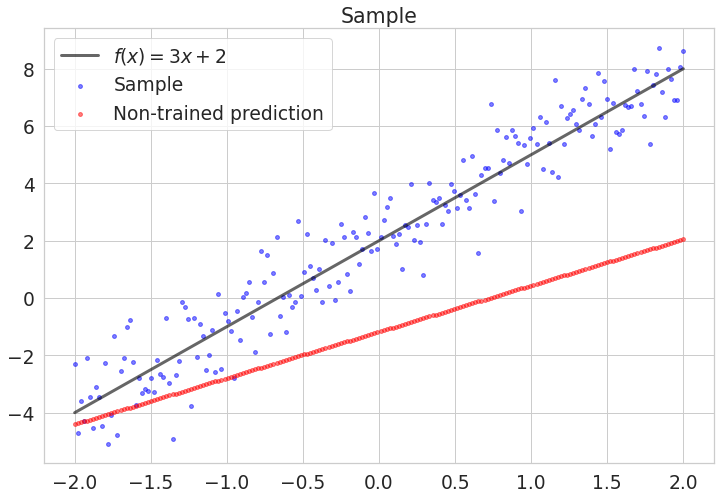

In [25]:
plt.figure(figsize=(12,8))
plt.title('Sample')
plt.scatter(x_data, y_data, s=15, alpha=0.5, color='blue', label='Sample')
plt.scatter(x_data, my_linear(x_data), s=15, alpha=0.5, color='red', label='Non-trained prediction')
plt.plot(x_data, f(x_data), color='black', lw=3, alpha=0.6, label=r'$f(x)=3x+2$')
plt.legend()
plt.show()

In [26]:
#------------------------------------------------------------------------------
# un passo del training
def train(model, x_train, y_train, learning_rate):
    
    with tf.GradientTape() as tape:
        current_loss = MSE(y_train, model(x_train))
        
    # calcola i gradienti rispetto ai due parametri
    dw, db = tape.gradient(current_loss, [model.w, model.b])

    # assign_sub ri-assegna il valore alla variabile di interesse (w o b \in model)
    # e ne sottrae il valore contenuto in (.) 
    # sto implementando in modo pratico la discesa del gradiente 
    model.w.assign_sub(learning_rate * dw)
    model.b.assign_sub(learning_rate * db)
    

#------------------------------------------------------------------------------
# il loop che costituisce l'intero training
def training(model, epochs, x_train, y_train):
        
    weights = []
    biases  = []
    

    for iepoch in range(epochs):
        # passo dell'addestramento
        train(model, x_train, y_train, learning_rate=0.1)

        # teniamo traccia dello storico di pesi e bias
        weights.append(model.w.numpy())
        biases.append(model.b.numpy())
        current_loss = MSE(y_train, model(x_train))

        # una stampa per vedere come vanno le cose
        print("Epoch ", iepoch, "/", epochs)
        print("w=", model.w.numpy(), " b=", model.b.numpy(), "loss=", current_loss.numpy()) 

    return weights, biases

        
#------------------------------------------------------------------------------
# funzione di controllo interessante copiata dal prof
def report(model, loss):
    return f"W = {model.w.numpy():1.2f}, b = {model.b.numpy():1.2f}, loss={loss:2.5f}"

In [27]:
weights, biases = training(my_linear, epochs=10, x_train=x_data, y_train=y_data)

Epoch  0 / 10
w= [1.9877744]  b= [-0.5214107] loss= 9.170229
Epoch  1 / 10
w= [2.2608812]  b= [0.00110048] loss= 6.0676427
Epoch  2 / 10
w= [2.4604275]  b= [0.4191095] loss= 4.150497
Epoch  3 / 10
w= [2.6062267]  b= [0.7535167] loss= 2.9600976
Epoch  4 / 10
w= [2.7127554]  b= [1.0210423] loss= 2.217767
Epoch  5 / 10
w= [2.790591]  b= [1.235063] loss= 1.7530991
Epoch  6 / 10
w= [2.8474617]  b= [1.4062794] loss= 1.4612763
Epoch  7 / 10
w= [2.8890145]  b= [1.5432526] loss= 1.2774804
Epoch  8 / 10
w= [2.9193752]  b= [1.6528312] loss= 1.1614369
Epoch  9 / 10
w= [2.9415584]  b= [1.740494] loss= 1.0880156


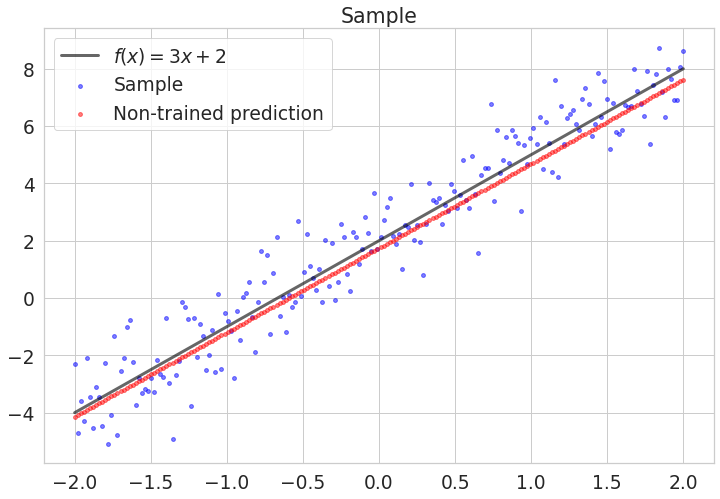

In [28]:
plt.figure(figsize=(12,8))
plt.title('Sample')
plt.scatter(x_data, y_data, s=15, alpha=0.5, color='blue', label='Sample')
plt.scatter(x_data, my_linear(x_data), s=15, alpha=0.5, color='red', label='Non-trained prediction')
plt.plot(x_data, f(x_data), color='black', lw=3, alpha=0.6, label=r'$f(x)=3x+2$')
plt.legend()
plt.show()

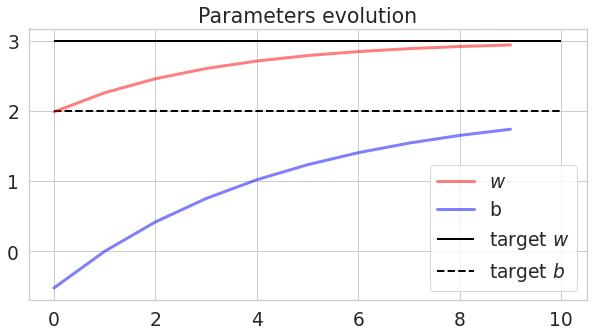

In [29]:
loops = np.arange(10)
plt.figure(figsize=(10,5))
plt.title('Parameters evolution')
plt.plot(loops, weights, label=r'$w$', lw=3, alpha=0.5, color='red')
plt.hlines(3, 0, 10, label=r'target $w$', lw=2, alpha=1, color='black')
plt.plot(loops, biases, label=r'b', lw=3, alpha=0.5, color='blue')
plt.hlines(2, 0, 10, label=r'target $b$', lw=2, alpha=1, color='black', ls='--')
plt.legend()
plt.show()

## 4 - Regression with sequential model

In [37]:
data = np.loadtxt("data.dat")

In [64]:
df = pd.DataFrame({ 'x_train' : list(data.T[0]), 'y_train' : list(data.T[1]),
                    'x_valid' : list(data.T[2]), 'y_valid' : list(data.T[3])})

print(df.head(4))

print('  ')
print('Dimensioni dei campioni')
len(df['x_train']), len(df['y_train']), len(df['x_valid']), len(df['y_valid'])

    x_train   y_train   x_valid   y_valid
0  0.000000 -2.772733  0.000000 -2.025782
1  0.015075 -2.415458  0.015075 -2.383896
2  0.030151 -2.740514  0.030151 -3.507091
3  0.045226 -3.262959  0.045226 -2.033963
  
Dimensioni dei campioni


(200, 200, 200, 200)

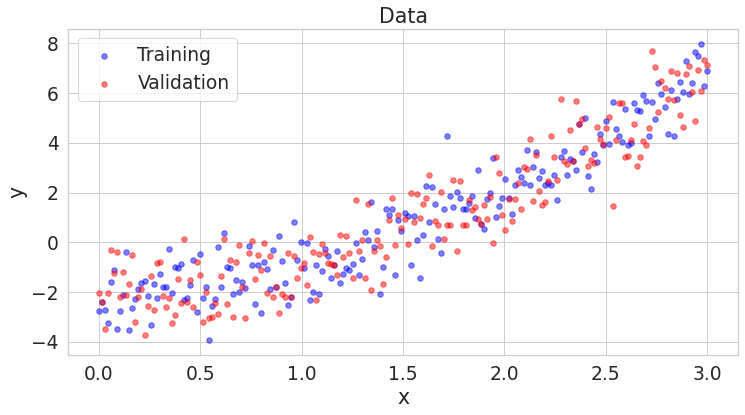

In [79]:
#un rapido sguardo ai dati
plt.figure(figsize=(12,6))
plt.title('Data')
plt.scatter(df['x_train'], df['y_train'], s=30, alpha=0.5, label='Training', color='blue')
plt.scatter(df['x_valid'], df['y_valid'], s=30, alpha=0.5, label='Validation', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [73]:
# un semplice modello lineare
# un neurone e un layer 
inputs = tf.keras.Input(shape=(1,))
outputs = tf.keras.layers.Dense(1, activation='linear')(inputs)

# salvo il modello nella variabile 'model'
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="BaselineLinearModel")

# compilo con MSE come funzione di costo e con ottimizzatore SGD
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD())

# fitto
history = model.fit(x= df['x_train'], y=df['y_train'], 
                    validation_data=(df['x_valid'], df['y_valid']), batch_size=200, epochs=500)

Epoch 1/500
1/1 [==============================] - 0s 304ms/step - loss: 15.6775 - val_loss: 14.0843
Epoch 2/500
1/1 [==============================] - 0s 30ms/step - loss: 14.1943 - val_loss: 12.8295
Epoch 3/500
1/1 [==============================] - 0s 34ms/step - loss: 12.9234 - val_loss: 11.7546
Epoch 4/500
1/1 [==============================] - 0s 41ms/step - loss: 11.8336 - val_loss: 10.8333
Epoch 5/500
1/1 [==============================] - 0s 28ms/step - loss: 10.8984 - val_loss: 10.0430
Epoch 6/500
1/1 [==============================] - 0s 37ms/step - loss: 10.0952 - val_loss: 9.3644
Epoch 7/500
1/1 [==============================] - 0s 60ms/step - loss: 9.4048 - val_loss: 8.7813
Epoch 8/500
1/1 [==============================] - 0s 38ms/step - loss: 8.8106 - val_loss: 8.2795
Epoch 9/500
1/1 [==============================] - 0s 42ms/step - loss: 8.2986 - val_loss: 7.8471
Epoch 10/500
1/1 [==============================] - 0s 51ms/step - loss: 7.8567 - val_loss: 7.4740
Epoch 1

1/1 [==============================] - 0s 32ms/step - loss: 3.5665 - val_loss: 3.6797
Epoch 84/500
1/1 [==============================] - 0s 37ms/step - loss: 3.5472 - val_loss: 3.6609
Epoch 85/500
1/1 [==============================] - 0s 32ms/step - loss: 3.5281 - val_loss: 3.6424
Epoch 86/500
1/1 [==============================] - 0s 22ms/step - loss: 3.5091 - val_loss: 3.6239
Epoch 87/500
1/1 [==============================] - 0s 31ms/step - loss: 3.4902 - val_loss: 3.6056
Epoch 88/500
1/1 [==============================] - 0s 26ms/step - loss: 3.4715 - val_loss: 3.5875
Epoch 89/500
1/1 [==============================] - 0s 23ms/step - loss: 3.4530 - val_loss: 3.5695
Epoch 90/500
1/1 [==============================] - 0s 24ms/step - loss: 3.4345 - val_loss: 3.5516
Epoch 91/500
1/1 [==============================] - 0s 25ms/step - loss: 3.4163 - val_loss: 3.5339
Epoch 92/500
1/1 [==============================] - 0s 23ms/step - loss: 3.3982 - val_loss: 3.5163
Epoch 93/500
1/1 [=====

1/1 [==============================] - 0s 29ms/step - loss: 2.3997 - val_loss: 2.5499
Epoch 166/500
1/1 [==============================] - 0s 33ms/step - loss: 2.3897 - val_loss: 2.5402
Epoch 167/500
1/1 [==============================] - 0s 28ms/step - loss: 2.3797 - val_loss: 2.5306
Epoch 168/500
1/1 [==============================] - 0s 27ms/step - loss: 2.3698 - val_loss: 2.5211
Epoch 169/500
1/1 [==============================] - 0s 25ms/step - loss: 2.3600 - val_loss: 2.5116
Epoch 170/500
1/1 [==============================] - 0s 28ms/step - loss: 2.3503 - val_loss: 2.5023
Epoch 171/500
1/1 [==============================] - 0s 21ms/step - loss: 2.3406 - val_loss: 2.4930
Epoch 172/500
1/1 [==============================] - 0s 28ms/step - loss: 2.3311 - val_loss: 2.4837
Epoch 173/500
1/1 [==============================] - 0s 26ms/step - loss: 2.3216 - val_loss: 2.4746
Epoch 174/500
1/1 [==============================] - 0s 26ms/step - loss: 2.3122 - val_loss: 2.4655
Epoch 175/500


1/1 [==============================] - 0s 31ms/step - loss: 1.7928 - val_loss: 1.9676
Epoch 248/500
1/1 [==============================] - 0s 43ms/step - loss: 1.7876 - val_loss: 1.9626
Epoch 249/500
1/1 [==============================] - 0s 31ms/step - loss: 1.7824 - val_loss: 1.9577
Epoch 250/500
1/1 [==============================] - 0s 28ms/step - loss: 1.7773 - val_loss: 1.9528
Epoch 251/500
1/1 [==============================] - 0s 36ms/step - loss: 1.7722 - val_loss: 1.9479
Epoch 252/500
1/1 [==============================] - 0s 33ms/step - loss: 1.7671 - val_loss: 1.9431
Epoch 253/500
1/1 [==============================] - 0s 34ms/step - loss: 1.7621 - val_loss: 1.9383
Epoch 254/500
1/1 [==============================] - 0s 37ms/step - loss: 1.7571 - val_loss: 1.9336
Epoch 255/500
1/1 [==============================] - 0s 27ms/step - loss: 1.7522 - val_loss: 1.9289
Epoch 256/500
1/1 [==============================] - 0s 24ms/step - loss: 1.7473 - val_loss: 1.9242
Epoch 257/500


Epoch 329/500
1/1 [==============================] - 0s 35ms/step - loss: 1.4772 - val_loss: 1.6687
Epoch 330/500
1/1 [==============================] - 0s 36ms/step - loss: 1.4745 - val_loss: 1.6662
Epoch 331/500
1/1 [==============================] - 0s 24ms/step - loss: 1.4718 - val_loss: 1.6636
Epoch 332/500
1/1 [==============================] - 0s 25ms/step - loss: 1.4691 - val_loss: 1.6611
Epoch 333/500
1/1 [==============================] - 0s 29ms/step - loss: 1.4664 - val_loss: 1.6587
Epoch 334/500
1/1 [==============================] - 0s 22ms/step - loss: 1.4638 - val_loss: 1.6562
Epoch 335/500
1/1 [==============================] - 0s 29ms/step - loss: 1.4612 - val_loss: 1.6537
Epoch 336/500
1/1 [==============================] - 0s 27ms/step - loss: 1.4586 - val_loss: 1.6513
Epoch 337/500
1/1 [==============================] - 0s 24ms/step - loss: 1.4560 - val_loss: 1.6489
Epoch 338/500
1/1 [==============================] - 0s 24ms/step - loss: 1.4535 - val_loss: 1.6465


Epoch 411/500
1/1 [==============================] - 0s 31ms/step - loss: 1.3130 - val_loss: 1.5161
Epoch 412/500
1/1 [==============================] - 0s 35ms/step - loss: 1.3116 - val_loss: 1.5148
Epoch 413/500
1/1 [==============================] - 0s 21ms/step - loss: 1.3102 - val_loss: 1.5136
Epoch 414/500
1/1 [==============================] - 0s 26ms/step - loss: 1.3088 - val_loss: 1.5123
Epoch 415/500
1/1 [==============================] - 0s 27ms/step - loss: 1.3074 - val_loss: 1.5110
Epoch 416/500
1/1 [==============================] - 0s 22ms/step - loss: 1.3061 - val_loss: 1.5098
Epoch 417/500
1/1 [==============================] - 0s 25ms/step - loss: 1.3047 - val_loss: 1.5085
Epoch 418/500
1/1 [==============================] - 0s 28ms/step - loss: 1.3034 - val_loss: 1.5073
Epoch 419/500
1/1 [==============================] - 0s 22ms/step - loss: 1.3020 - val_loss: 1.5061
Epoch 420/500
1/1 [==============================] - 0s 27ms/step - loss: 1.3007 - val_loss: 1.5049


Epoch 493/500
1/1 [==============================] - 0s 49ms/step - loss: 1.2276 - val_loss: 1.4388
Epoch 494/500
1/1 [==============================] - 0s 34ms/step - loss: 1.2269 - val_loss: 1.4382
Epoch 495/500
1/1 [==============================] - 0s 26ms/step - loss: 1.2262 - val_loss: 1.4375
Epoch 496/500
1/1 [==============================] - 0s 27ms/step - loss: 1.2254 - val_loss: 1.4369
Epoch 497/500
1/1 [==============================] - 0s 33ms/step - loss: 1.2247 - val_loss: 1.4363
Epoch 498/500
1/1 [==============================] - 0s 28ms/step - loss: 1.2240 - val_loss: 1.4356
Epoch 499/500
1/1 [==============================] - 0s 33ms/step - loss: 1.2233 - val_loss: 1.4350
Epoch 500/500
1/1 [==============================] - 0s 26ms/step - loss: 1.2226 - val_loss: 1.4344


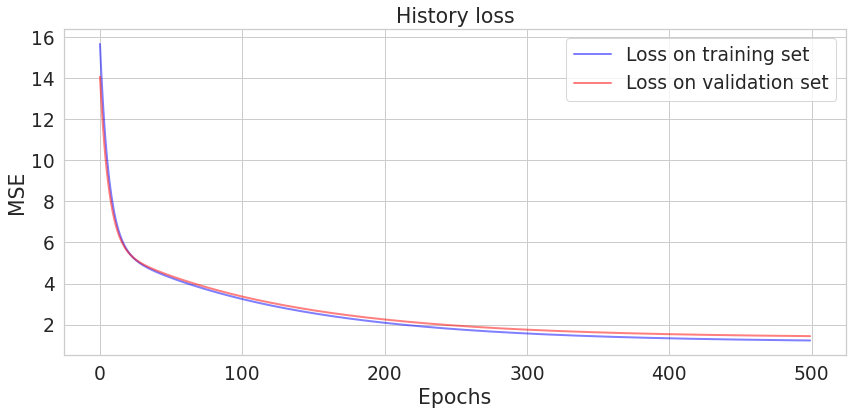

In [77]:
plt.figure(figsize=(14,6))
plt.title('History loss')
plt.plot(history.history['loss'], color='blue', lw=2, alpha=0.5, label='Loss on training set')
plt.plot(history.history['val_loss'], color='red', lw=2, alpha=0.5, label='Loss on validation set')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [86]:
x_new = np.linspace(0,3,50)
y_new = model.predict(x_new)

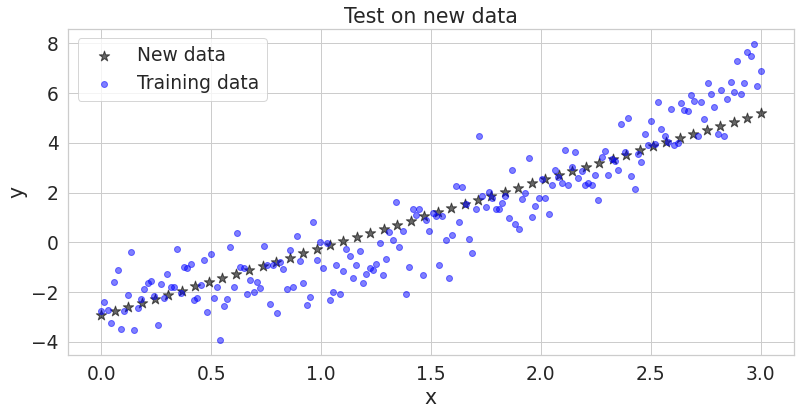

In [93]:
plt.figure(figsize=(13,6))
plt.title('Test on new data')
plt.scatter(x_new, y_new, label='New data', color='black', marker='*', s=120, alpha=0.6)
plt.scatter(df['x_train'], df['y_train'], label='Training data', color='blue', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [95]:
# un semplice modello lineare
# un neurone e un layer 
inputs = tf.keras.Input(shape=(1,))
x1 = tf.keras.layers.Dense(10, activation='relu')(inputs)
x2 = tf.keras.layers.Dense(10, activation='relu')(x1)
x3 = tf.keras.layers.Dense(10, activation='relu')(x2)
outputs = tf.keras.layers.Dense(1, activation='linear')(x3)

# salvo il modello nella variabile 'model'
model_3hl = tf.keras.Model(inputs=inputs, outputs=outputs, name="3hiddenModel")

# compilo con MSE come funzione di costo e con ottimizzatore SGD
model_3hl.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD())

# fitto
history_3hl = model_3hl.fit(x= df['x_train'], y=df['y_train'], 
                    validation_data=(df['x_valid'], df['y_valid']), batch_size=200, epochs=500)

Epoch 1/500
1/1 [==============================] - 0s 395ms/step - loss: 8.3156 - val_loss: 8.0866
Epoch 2/500
1/1 [==============================] - 0s 23ms/step - loss: 8.1037 - val_loss: 7.8705
Epoch 3/500
1/1 [==============================] - 0s 32ms/step - loss: 7.8828 - val_loss: 7.6436
Epoch 4/500
1/1 [==============================] - 0s 26ms/step - loss: 7.6507 - val_loss: 7.4036
Epoch 5/500
1/1 [==============================] - 0s 50ms/step - loss: 7.4049 - val_loss: 7.1498
Epoch 6/500
1/1 [==============================] - 0s 56ms/step - loss: 7.1448 - val_loss: 6.8833
Epoch 7/500
1/1 [==============================] - 0s 42ms/step - loss: 6.8711 - val_loss: 6.6070
Epoch 8/500
1/1 [==============================] - 0s 44ms/step - loss: 6.5869 - val_loss: 6.3260
Epoch 9/500
1/1 [==============================] - 0s 43ms/step - loss: 6.2971 - val_loss: 6.0479
Epoch 10/500
1/1 [==============================] - 0s 34ms/step - loss: 6.0096 - val_loss: 5.7813
Epoch 11/500
1/1 [

Epoch 84/500
1/1 [==============================] - 0s 39ms/step - loss: 1.2430 - val_loss: 1.4438
Epoch 85/500
1/1 [==============================] - 0s 26ms/step - loss: 1.2316 - val_loss: 1.4342
Epoch 86/500
1/1 [==============================] - 0s 26ms/step - loss: 1.2207 - val_loss: 1.4250
Epoch 87/500
1/1 [==============================] - 0s 29ms/step - loss: 1.2102 - val_loss: 1.4162
Epoch 88/500
1/1 [==============================] - 0s 24ms/step - loss: 1.2001 - val_loss: 1.4077
Epoch 89/500
1/1 [==============================] - 0s 30ms/step - loss: 1.1904 - val_loss: 1.3996
Epoch 90/500
1/1 [==============================] - 0s 27ms/step - loss: 1.1811 - val_loss: 1.3919
Epoch 91/500
1/1 [==============================] - 0s 27ms/step - loss: 1.1723 - val_loss: 1.3843
Epoch 92/500
1/1 [==============================] - 0s 24ms/step - loss: 1.1638 - val_loss: 1.3771
Epoch 93/500
1/1 [==============================] - 0s 33ms/step - loss: 1.1556 - val_loss: 1.3700
Epoch 94/5

1/1 [==============================] - 0s 30ms/step - loss: 0.9219 - val_loss: 1.1661
Epoch 167/500
1/1 [==============================] - 0s 32ms/step - loss: 0.9207 - val_loss: 1.1649
Epoch 168/500
1/1 [==============================] - 0s 27ms/step - loss: 0.9196 - val_loss: 1.1638
Epoch 169/500
1/1 [==============================] - 0s 35ms/step - loss: 0.9184 - val_loss: 1.1627
Epoch 170/500
1/1 [==============================] - 0s 29ms/step - loss: 0.9173 - val_loss: 1.1616
Epoch 171/500
1/1 [==============================] - 0s 32ms/step - loss: 0.9162 - val_loss: 1.1605
Epoch 172/500
1/1 [==============================] - 0s 39ms/step - loss: 0.9151 - val_loss: 1.1595
Epoch 173/500
1/1 [==============================] - 0s 58ms/step - loss: 0.9141 - val_loss: 1.1584
Epoch 174/500
1/1 [==============================] - 0s 81ms/step - loss: 0.9130 - val_loss: 1.1574
Epoch 175/500
1/1 [==============================] - 0s 46ms/step - loss: 0.9120 - val_loss: 1.1563
Epoch 176/500


1/1 [==============================] - 0s 26ms/step - loss: 0.8666 - val_loss: 1.1064
Epoch 249/500
1/1 [==============================] - 0s 29ms/step - loss: 0.8663 - val_loss: 1.1059
Epoch 250/500
1/1 [==============================] - 0s 24ms/step - loss: 0.8659 - val_loss: 1.1055
Epoch 251/500
1/1 [==============================] - 0s 23ms/step - loss: 0.8655 - val_loss: 1.1050
Epoch 252/500
1/1 [==============================] - 0s 28ms/step - loss: 0.8652 - val_loss: 1.1045
Epoch 253/500
1/1 [==============================] - 0s 26ms/step - loss: 0.8648 - val_loss: 1.1041
Epoch 254/500
1/1 [==============================] - 0s 25ms/step - loss: 0.8645 - val_loss: 1.1036
Epoch 255/500
1/1 [==============================] - 0s 24ms/step - loss: 0.8641 - val_loss: 1.1032
Epoch 256/500
1/1 [==============================] - 0s 22ms/step - loss: 0.8638 - val_loss: 1.1027
Epoch 257/500
1/1 [==============================] - 0s 23ms/step - loss: 0.8635 - val_loss: 1.1023
Epoch 258/500


1/1 [==============================] - 0s 23ms/step - loss: 0.8495 - val_loss: 1.0830
Epoch 331/500
1/1 [==============================] - 0s 26ms/step - loss: 0.8494 - val_loss: 1.0828
Epoch 332/500
1/1 [==============================] - 0s 29ms/step - loss: 0.8493 - val_loss: 1.0827
Epoch 333/500
1/1 [==============================] - 0s 22ms/step - loss: 0.8492 - val_loss: 1.0825
Epoch 334/500
1/1 [==============================] - 0s 29ms/step - loss: 0.8491 - val_loss: 1.0824
Epoch 335/500
1/1 [==============================] - 0s 28ms/step - loss: 0.8490 - val_loss: 1.0823
Epoch 336/500
1/1 [==============================] - 0s 31ms/step - loss: 0.8489 - val_loss: 1.0821
Epoch 337/500
1/1 [==============================] - 0s 23ms/step - loss: 0.8488 - val_loss: 1.0820
Epoch 338/500
1/1 [==============================] - 0s 26ms/step - loss: 0.8487 - val_loss: 1.0818
Epoch 339/500
1/1 [==============================] - 0s 34ms/step - loss: 0.8486 - val_loss: 1.0817
Epoch 340/500


1/1 [==============================] - 0s 34ms/step - loss: 0.8446 - val_loss: 1.0754
Epoch 413/500
1/1 [==============================] - 0s 33ms/step - loss: 0.8446 - val_loss: 1.0754
Epoch 414/500
1/1 [==============================] - 0s 31ms/step - loss: 0.8446 - val_loss: 1.0753
Epoch 415/500
1/1 [==============================] - 0s 27ms/step - loss: 0.8445 - val_loss: 1.0753
Epoch 416/500
1/1 [==============================] - 0s 33ms/step - loss: 0.8445 - val_loss: 1.0752
Epoch 417/500
1/1 [==============================] - 0s 30ms/step - loss: 0.8445 - val_loss: 1.0751
Epoch 418/500
1/1 [==============================] - 0s 38ms/step - loss: 0.8444 - val_loss: 1.0751
Epoch 419/500
1/1 [==============================] - 0s 29ms/step - loss: 0.8444 - val_loss: 1.0750
Epoch 420/500
1/1 [==============================] - 0s 26ms/step - loss: 0.8444 - val_loss: 1.0750
Epoch 421/500
1/1 [==============================] - 0s 32ms/step - loss: 0.8443 - val_loss: 1.0749
Epoch 422/500


1/1 [==============================] - 0s 25ms/step - loss: 0.8425 - val_loss: 1.0721
Epoch 495/500
1/1 [==============================] - 0s 27ms/step - loss: 0.8424 - val_loss: 1.0721
Epoch 496/500
1/1 [==============================] - 0s 25ms/step - loss: 0.8424 - val_loss: 1.0720
Epoch 497/500
1/1 [==============================] - 0s 33ms/step - loss: 0.8424 - val_loss: 1.0720
Epoch 498/500
1/1 [==============================] - 0s 27ms/step - loss: 0.8424 - val_loss: 1.0720
Epoch 499/500
1/1 [==============================] - 0s 28ms/step - loss: 0.8424 - val_loss: 1.0720
Epoch 500/500
1/1 [==============================] - 0s 27ms/step - loss: 0.8423 - val_loss: 1.0719


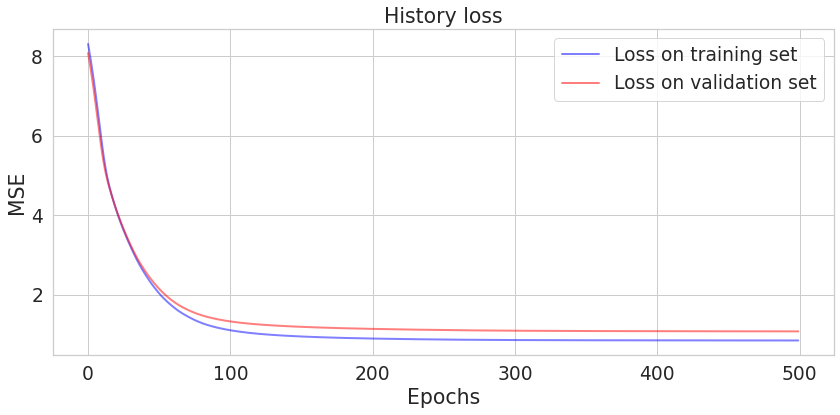

In [96]:
plt.figure(figsize=(14,6))
plt.title('History loss')
plt.plot(history_3hl.history['loss'], color='blue', lw=2, alpha=0.5, label='Loss on training set')
plt.plot(history_3hl.history['val_loss'], color='red', lw=2, alpha=0.5, label='Loss on validation set')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [97]:
y_new_3hl = model_3hl.predict(x_new)

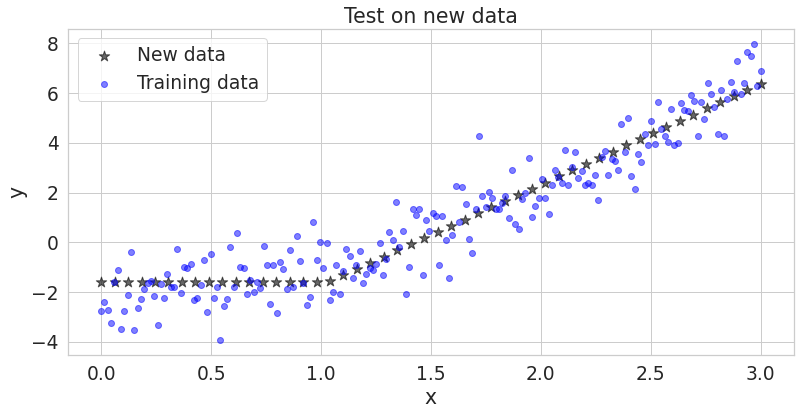

In [98]:
plt.figure(figsize=(13,6))
plt.title('Test on new data')
plt.scatter(x_new, y_new_3hl, label='New data', color='black', marker='*', s=120, alpha=0.6)
plt.scatter(df['x_train'], df['y_train'], label='Training data', color='blue', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()